In [3]:
############ Packages ############

# Write in the terminal
#!pip install spacy pandas nltk unidecode
#!python -m spacy download fr_core_news_sm

# Libraries import
import os
import re
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from IPython.display import display, HTML

In [1]:
#########################Configuration ###########################

#path_to_files = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981"
path_to_files = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1993"

#csv_path="/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981.csv"
csv_path="/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1993.csv"



## Exploration des données

In [2]:
############ Reading the content of the first manifestos #############

# List of .txt files
txt_files = [f for f in os.listdir(path_to_files) if f.endswith(".txt")]


## Loop through the first 5 files and read content

first_five_files = txt_files[:3]

for i, filename in enumerate(first_five_files, 1):
    filepath = os.path.join(path_to_files, filename)
    
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    
    # 800 first caracters
    raw_preview = content[:800]
    
    # Display preview
    header = f"<h3 style='color: #d9534f; border-bottom: 2px solid #d9534f; padding-bottom: 5px;'>Document {i} : {filename}</h3>"
    
    html_code = f"""
    <div style="
        background-color: #ffffff; 
        color: #333; 
        padding: 20px; 
        border-radius: 8px; 
        box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        font-family: 'Consolas', 'Monaco', monospace;
        font-size: 1em;
        line-height: 1.4;
        border-left: 5px solid #d9534f;
        margin-bottom: 20px;
        /* LE SECRET EST ICI : */
        white-space: pre-wrap; 
        word-wrap: break-word;
    ">
{raw_preview}...
    </div>
    """
    
    display(HTML(header + html_code))

NameError: name 'os' is not defined

In [4]:
############ Exploring the CSV content #############

df = pd.read_csv(csv_path, encoding="utf-8")

# Column names 
print("--------------- Column names / Attributes --------------")
print(df.columns)


--------------- Column names / Attributes --------------
Index(['id', 'date', 'subject', 'title', 'contexte-election', 'contexte-tour',
       'cote', 'departement', 'departement-nom', 'departement-insee',
       'identifiant de circonscription', 'images', 'pdf', 'ocr_url',
       'titulaire-nom', 'titulaire-prenom', 'titulaire-sexe', 'titulaire-age',
       'titulaire-age-calcule', 'titulaire-age-tranche',
       'titulaire-profession', 'titulaire-mandat-en-cours',
       'titulaire-mandat-passe', 'titulaire-associations',
       'titulaire-autres-statuts', 'titulaire-soutien', 'titulaire-liste',
       'titulaire-decorations', 'suppleant-nom', 'suppleant-prenom',
       'suppleant-sexe', 'suppleant-age', 'suppleant-age-calcule',
       'suppleant-age-tranche', 'suppleant-profession',
       'suppleant-mandat-en-cours', 'suppleant-mandat-passe',
       'suppleant-associations', 'suppleant-autres-statuts',
       'suppleant-soutien', 'suppleant-liste', 'suppleant-decorations'],
      d

In [5]:
############ Display the first 5 rows of the csv for columns of interest ################

print("\n--------------- First 5 rows of the DataFrame ---------------")

# List of columns to display
columns_to_show = ['id', 'contexte-election', 'contexte-tour', 'titulaire-soutien', 'titulaire-liste']

# Display only these columns
display(df[columns_to_show].head())



--------------- First 5 rows of the DataFrame ---------------


,id,contexte-election,contexte-tour,titulaire-soutien,titulaire-liste
0,EL189_L_1993_03_001_01_1_PF_01,législatives,1,Front national,non mentionné
1,EL189_L_1993_03_001_01_1_PF_02,législatives,1,Parti communiste français,non mentionné
2,EL189_L_1993_03_001_01_1_PF_03,législatives,1,Union pour la démocratie française;Rassembleme...,non mentionné
3,EL189_L_1993_03_001_01_1_PF_04,législatives,1,Lutte ouvrière,non mentionné
4,EL189_L_1993_03_001_01_1_PF_05,législatives,1,Verts;Génération écologie,Entente des écologistes


We will focus on manifestos from the first round of the legislative elections to avoid including alliances, which could introduce confusion and distort the analysis, and to keep more parties, even those that do not reach the second round. This ensures a more accurate and representative prediction of each party’s individual positions, as each party presents its candidates and manifestos independently.

In [6]:
################ Keep only manifestos from the first round ###########################
df_first_round = df[df['contexte-tour'] == 1].copy()

# Reset index for clean dataframe
df_first_round = df_first_round.reset_index(drop=True)


In [7]:
############ DATA QUALITY CHECK: LABELLING COMPLETENESS ############
## This block quantifies metadata "noise" by aggregating missing values (NaN), 
## empty strings, and 'non mentionné' placeholders.

# Columns to check
cols = ['titulaire-soutien', 'titulaire-liste']

for col in cols:
    # Count NaN (missing values)
    num_missing = df_first_round[col].isna().sum()
    
    # Count empty strings
    num_empty = (df_first_round[col] == '').sum()
    
    # Count cells with 'Non mentionné'
    num_non_mentionne = (df_first_round[col] == 'non mentionné').sum()
    
    # Total not mentioned
    total_not_mentioned = num_missing + num_empty + num_non_mentionne
    
    print(f"-- Column '{col}' (1er TOUR) --")
    print(f"Number of modalities 'non mentionné' (NaN, empty, 'non mentionné'): {total_not_mentioned}\n")

print("-- Total number of modalities --")
print(f"Total number of rows: {len(df_first_round)}\n")



-- Column 'titulaire-soutien' (1er TOUR) --
Number of modalities 'non mentionné' (NaN, empty, 'non mentionné'): 654

-- Column 'titulaire-liste' (1er TOUR) --
Number of modalities 'non mentionné' (NaN, empty, 'non mentionné'): 3123

-- Total number of modalities --
Total number of rows: 4872



In [8]:
############ CATEGORICAL DISTRIBUTION ############
## This function computes the frequency of each political modality (party, support).

def display_counts(df, col_name):
    # Calculate frequency counts and convert the index to a proper column
    counts = df[col_name].value_counts().reset_index()
    counts.columns = ['Modality', 'Count']
    
    # Truncate long strings to 50 characters to prevent table overflow/misalignment
    counts['Modality'] = counts['Modality'].astype(str).apply(
        lambda x: x[:50] + '...' if len(x) > 50 else x
    )
    
    # Display the result
    print(f"\n--- Distribution for: {col_name} (1er tour)---")
    display(counts)

display_counts(df_first_round, 'titulaire-soutien')
display_counts(df_first_round, 'titulaire-liste')


--- Distribution for: titulaire-soutien (1er tour)---


,Modality,Count
0,non mentionné,654
1,Front national,552
2,Parti communiste français,522
3,Nouveaux écologistes du rassemblement nature e...,387
4,Verts;Génération écologie,293
...,...,...
279,Union pour la démocratie française;Rassembleme...,1
280,Parti républicain,1
281,droite autonome,1
282,Région verte;EDEN;SOS environnement;Union des ...,1



--- Distribution for: titulaire-liste (1er tour)---


,Modality,Count
0,non mentionné,3123
1,Entente des écologistes,541
2,Alliance des Français pour le progrès,324
3,Union pour la France,268
4,A gauche vraiment,67
...,...,...
204,A gauche toute,1
205,Rassemblement de la droite,1
206,Dimension écologie,1
207,Une écologie indépendante à l'Assemblée,1


## Treatment of "Non mentionné" and Analysis of Modalities

To choose beetween the modalities `titulaire-soutien` and `titulaire-liste` in our prediction, we will:

1. **Filter out rows** that are either `NaN`, empty (`""`), or `"Non mentionné"` to create a cleaned dataset.
2. **Count occurrences** of each valid modality and classify them into intervals (bins) according to the number of manifestos:  
   - 0–10, 10–20, 20–30, 30–40, 40–50, 50+
3. Compute **summary tables and histograms**


We subsequently analyze the distribution of manifestos across the most frequent categories to ensure an adequate sample size for robust statistical learning.


In [9]:
################# DATA STRATIFICATION AND SELECTION CRITERIA ################# 

def analyze_category_distribution(df, cols):
    """
    Cleans the dataframe and analyzes the distribution of most frequent modalities 
    """
    categories_30_plus_dict = {}
    
    # Bins
    bins = [0, 10, 20, 30, 40, 50, float('inf')]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50+']
    
    working_df = df.copy()

    for col in cols:
        # Remove invalid entries
        invalid_mask = (working_df[col].isna()) | (working_df[col] == '') | (working_df[col] == 'non mentionné')
        working_df = working_df[~invalid_mask]
        
        print(f"\n--- Analysis for Column: '{col}' ---")
        print(f"Cleaned dataset size: {len(working_df)} rows")
        
        # Count occurrences of each modality
        counts = working_df[col].value_counts()
        
        # Record categories meeting the N>=30 threshold
        num_30_plus = (counts >= 30).sum()
        categories_30_plus_dict[col] = num_30_plus
        print(f"Number of categories with at least 30 manifestos: {num_30_plus}")
        
        # Correction: removed 'observed' parameter and simplified grouping logic
        binned = pd.cut(counts, bins=bins, labels=labels, right=False)
        
        # Modalities per bin
        summary_modalities = binned.value_counts().sort_index()
        
        # Total manifestos per bin - Improved logic for universal compatibility
        summary_manifestos = counts.groupby(binned).sum().reindex(labels).fillna(0).astype(int)
        
        # Summary table
        summary_df = pd.DataFrame({
            'Number of modalities': summary_modalities,
            'Number of manifestos': summary_manifestos
        })
        
        # Add Total row
        total_row = pd.DataFrame({
            'Number of modalities': [summary_df['Number of modalities'].sum()],
            'Number of manifestos': [summary_df['Number of manifestos'].sum()]
        }, index=['Total'])
        
        summary_df = pd.concat([summary_df, total_row])
        display(summary_df)
        
    return categories_30_plus_dict

# Execution
final_30_plus_stats = analyze_category_distribution(df_first_round, ['titulaire-soutien', 'titulaire-liste'])


--- Analysis for Column: 'titulaire-soutien' ---
Cleaned dataset size: 4218 rows
Number of categories with at least 30 manifestos: 27


/tmp/ipykernel_225225/2416604428.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_manifestos = counts.groupby(binned).sum().reindex(labels).fillna(0).astype(int)


,Number of modalities,Number of manifestos
0-10,244,410
10-20,8,108
20-30,4,88
30-40,6,213
40-50,2,93
50+,19,3306
Total,283,4218



--- Analysis for Column: 'titulaire-liste' ---
Cleaned dataset size: 1387 rows
Number of categories with at least 30 manifestos: 8


/tmp/ipykernel_225225/2416604428.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_manifestos = counts.groupby(binned).sum().reindex(labels).fillna(0).astype(int)


,Number of modalities,Number of manifestos
0-10,117,180
10-20,4,61
20-30,0,0
30-40,2,71
40-50,2,81
50+,4,994
Total,129,1387


It appears that 53% of the manifestos appear in at least 30 manifestos, whereas 62% of the manifestos appear in at least 30 manifestos.
Therefore, we choose to work with the 'titulaire-soutien' as variable to implement our classifier model. So we have a total of **1,920 usable manifestos** for NLP algorithms, noting that we consider we need at least 30 manifestos per category to make reliable predictions.
Indeed, the graph below shows that, for the variable titulaire-liste, most modalities that occur in strictly fewer than 30 manifestos appear in less than five manifestos. This makes predicting the list practically infeasible.

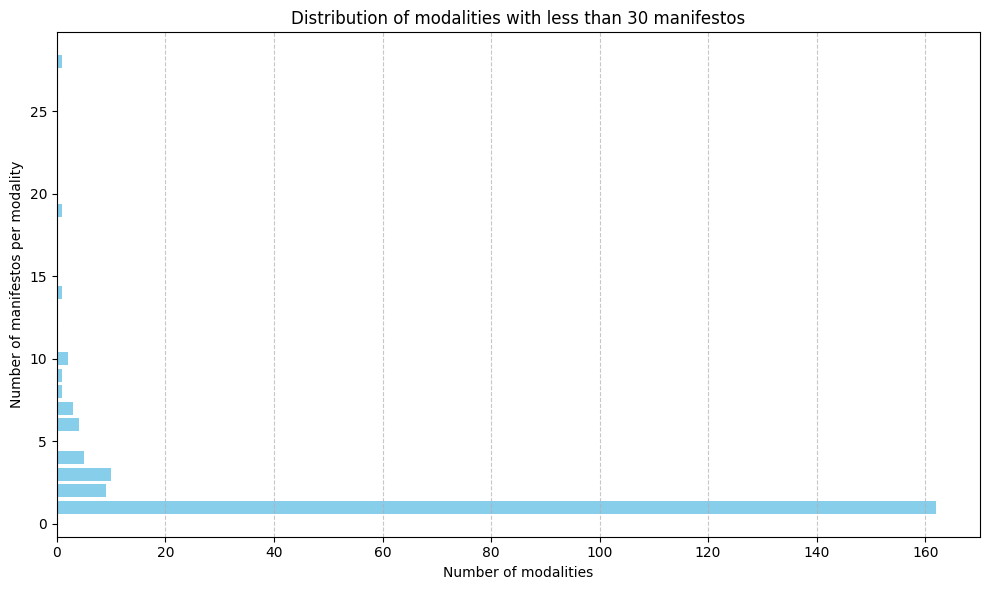

In [10]:
# Count the number of manifestos per modality
counts = df_first_round['titulaire-liste'].value_counts()

# Keep only modalities with strictly less than 30 manifestos
counts_under_30 = counts[counts < 30]

# Count how many modalities have each number of manifestos
freq_of_counts = counts_under_30.value_counts().sort_index()

# Plot horizontal bar chart
plt.figure(figsize=(10,6))
plt.barh(freq_of_counts.index, freq_of_counts.values, color='skyblue')
plt.xlabel("Number of modalities")
plt.ylabel("Number of manifestos per modality")
plt.title("Distribution of modalities with less than 30 manifestos")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


From this point onward, we work exclusively with the unified and cleaned dataframe. This dataset, merging the CSV metadata and the text files), includes only categories with more than 30 manifestos and excludes all observations for which the political support is not identified. 


In [13]:
from create_dataframe import prepare_legislatives_dataset

df_final = prepare_legislatives_dataset(csv_path, path_to_files)

len(df_final)


3612

## Statistiques descriptives

#### Number of exploitable manifestos and number of categories

As seen before, we have a total of **1,920 usable manifestos** for NLP algorithms and **13 modalities** associated to this manifestos.


--- Summary Table (Verified Categories) ---


,Category,Number of manifestos
0,Front national,552
1,Parti communiste français,522
2,Nouveaux écologistes du rassemblement nature e...,387
3,Verts;Génération écologie,293
4,Lutte ouvrière,234
5,Rassemblement pour la République;Union pour la...,200
6,Parti socialiste,192
7,Union pour la démocratie française;Rassembleme...,170
8,Génération écologie;Verts,114
9,Parti de la loi naturelle,94


/tmp/ipykernel_225225/1077527475.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


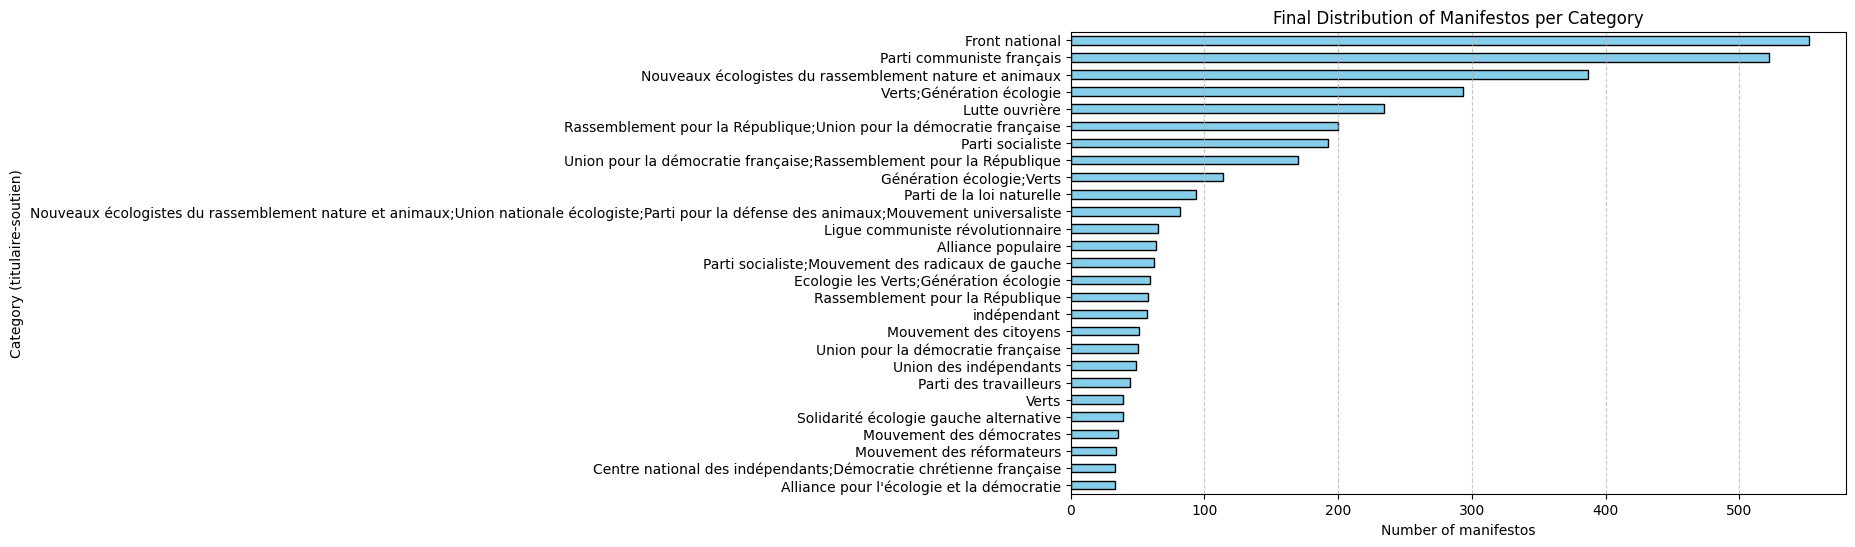

In [14]:
# Counts and visualizes political manifestos for 'titulaire-soutien'
# Only categories with more than 30 manifestos

# Count manifestos from the already filtered dataframe
counts = df_final ['titulaire-soutien'].value_counts()

# Create summary table
summary_df = pd.DataFrame({
    'Category': counts.index,
    'Number of manifestos': counts.values
})

print("\n--- Summary Table (Verified Categories) ---")
display(summary_df) # Use display() for a cleaner table in Notebooks

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
counts.plot(kind='barh', color='skyblue', edgecolor='black')

# Formatting
plt.xlabel("Number of manifestos")
plt.ylabel("Category (titulaire-soutien)")
plt.title("Final Distribution of Manifestos per Category")
plt.gca().invert_yaxis()  # Largest values on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()



The goal of this module is to:
- Understand the raw structure of the corpus   
- Detect potential OCR or formatting issues 

In [17]:
## --- TEXTUAL ANALYSIS AND LEXICAL STATISTICS ---
## This module processes text content to compute lexical richness and stylistic metrics

def run_textual_analysis(df_input):
    """
    Computes lexical metrics and cleans text. 
    """
    
    # --- INTERNAL UTILITIES ---
    def _preprocess(text):
        text = str(text).lower()
        text = re.sub(r'[^\w\s]', '', text)
        tokens = text.split()
        return [t for t in tokens if t != ""]

    def _count_sentences(text):
        sentences = re.split(r'[.!?]+', str(text))
        return len([s.strip() for s in sentences if s.strip() != ""])

    def _get_hapax_ratio(tokens):
        if not tokens: return 0
        counts = Counter(tokens)
        return sum(1 for w in counts if counts[w] == 1) / len(tokens)

    df = df_input.copy()
    
    # Basic tokens and counts
    df["tokens"] = df["text_content"].apply(_preprocess)
    df["nb_words"] = df["tokens"].apply(len)
    df["nb_sentences"] = df["text_content"].apply(_count_sentences)
    
    # Document-level stats
    df["words_per_sentence"] = df["nb_words"] / df["nb_sentences"].replace(0, np.nan)
    df["vocab_size_doc"] = df["tokens"].apply(lambda x: len(set(x)))
    df["ttr"] = df["vocab_size_doc"] / df["nb_words"].replace(0, np.nan)
    df["hapax_ratio"] = df["tokens"].apply(_get_hapax_ratio)

    # Corpus-level stats
    all_tokens = [t for sublist in df["tokens"] for t in sublist]
    word_counts = Counter(all_tokens)
    
    total_words = len(all_tokens)
    vocab_size = len(word_counts)
    hapax_corpus = sum(1 for w in word_counts if word_counts[w] == 1)
    corrected_ttr = vocab_size / np.sqrt(2 * total_words) if total_words > 0 else 0

    # DISPLAY
    print("===== Document-level averages =====")
    metrics = ["nb_words", "nb_sentences", "words_per_sentence", "vocab_size_doc", "ttr", "hapax_ratio"]
    for m in metrics:
        print(f"Average {m}: {df[m].mean():.4f}")

    print("\n===== Corpus-level statistics =====")
    print(f"Total words: {total_words} | Vocab size: {vocab_size}")
    print(f"Corpus hapax count: {hapax_corpus} | Corrected TTR: {corrected_ttr:.4f}")

    return df, {"total_words": total_words, "vocab_size": vocab_size, "corrected_ttr": corrected_ttr}

# EXECUTION
df_valid, global_stats = run_textual_analysis(df_final)

===== Document-level averages =====
Average nb_words: 705.9975
Average nb_sentences: 38.0479
Average words_per_sentence: 19.5162
Average vocab_size_doc: 352.5184
Average ttr: 0.5237
Average hapax_ratio: 0.3854

===== Corpus-level statistics =====
Total words: 1134538 | Vocab size: 35684
Corpus hapax count: 16571 | Corrected TTR: 23.6891


The results above indicate that the corpus is composed of relatively short texts (typically equivalent to a double-sided page, which is standard for electoral materials). However, the manifestos contain relatively long sentences (19 words on average, compared to approximately 15 words in a modern newspaper article). They also exhibit a relatively high Type-Token Ratio (TTR = 0.54), meaning that more than one out of every two words is unique within a given text. Together, these indicators suggest a formal and structured writing style, with candidates employing varied, precise, and diversified vocabulary, and potentially displaying substantial syntactic complexity.
Because the standard TTR naturally decreases as text length increases (due to the repetition of function words such as “the”, “and”, etc.), we also compute the corrected TTR using Guiraud’s index. The corrected TTR (26.79) stabilizes this measure and confirms a high level of lexical richness, consistent with intellectually dense political discourse.

Moreover, the corpus exhibits low lexical redundancy, as reflected in the Hapax Ratio (39.5%). Nearly 40% of the words used in a document appear only once within that document. This suggests a high degree of lexical precision: rather than merely repeating slogans, candidates tend to develop arguments using specific and specialized terms.
The high proportion of hapax legomena also indicates strong heterogeneity across candidates or parties. It suggests that each candidate introduces their own distinctive vocabulary, potentially reflecting local references as proper nouns.

However, caution is required in interpreting these indicators. High lexical richness and a large hapax ratio may partly reflect OCR noise, the presence of numerous proper nouns, or highly localized and context-specific terminology. 
